## **Quantum transport in presece of Rashba spin-orbit coupling**

Let us consider the following Hamiltonian
$$
\hat{H} = -\frac{\hbar^2}{2m} (\partial_x^2 + \partial_y^2) + i \tilde{\alpha} (\sigma_x \partial_y - \sigma_y \partial_x) + B_z  \sigma_z + V(x,y)\;.
$$
In the equation above, $\tilde{\alpha} = \alpha_R \mathcal{E}_z$, $\alpha_R$ being the naked Rashba SO coupling strength and $\mathcal{E}_z$ the electric field normal to the surface. Besides the standard Zeeman term, we set $V(x,y) = 0$.

In [1]:
# quantum processes with kwant
import kwant

# linear algebra support and  numpy
import numpy as np
import scipy.sparse.linalg as sla
import scipy.linalg as la

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc

# enable tex fonts
mpl.rcParams['text.usetex'] = True

In [2]:
# define the Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

### **Implementing the Rashba spin-orbit coupling in a 2d box**

The Hamiltonian is the one provided in the problem statement. We consider a simple square lattice, with lattice constant $a$, such that the hopping energy is defined by $t = \hbar^2/(2ma^2)$.
The shape of the scattering region is a rectangle (i.e. a 2D box), with leads attached on the left and right side. We specify by hand the onsite potential and the hopping terms (see codes), one could eventually use the `discretizer` provided by the package.

We give an elemntary routine to compute the conductance from the s-matrix (internal solver of `kwant`). The function we specify requires all parameters to be already specified, we just change the energy to observe the quantization of conductance. We also compute the local density of states.

In [3]:
def make_box(a: float, Lmax: int, Wmax: int, Bz: float, alpha: float, lead_choice: str, plot_choice: str):

    # defining a square lattice with constant 'a' and 2 orbitals per site (spin up vs. spin down)
    lat = kwant.lattice.square(norbs = 2) 
    # hopping energy
    t = 1 / (2 * a**2)
    
    if plot_choice == 'yes':
        print('Hopping energy [t] = ', t)


    # define the shape of the scattering region
    def shape_box(pos):
        (x,y) = pos
        return (0 <= x <= Lmax) and (0 <= y <= Wmax) 
    
    system = kwant.Builder() 

    # ******* define the scattering region *******
    # on-site energy
    system[lat.shape(shape_box, (0,0))] = 4 * t * sigma_0 + Bz * sigma_z

    # hopping energy in the x-direction 
    system[kwant.builder.HoppingKind((1,0), lat, lat)] = -t * sigma_0  + 1j * alpha * sigma_y / (2*a)

    # hopping energy in the y-direction
    system[kwant.builder.HoppingKind((0,1), lat, lat)] = -t * sigma_0 - 1j * alpha * sigma_x / (2*a)


    # ******* define the leads *******
    if lead_choice == 'yes':
        lead_symmetry = kwant.TranslationalSymmetry((-1,0))
        lead = kwant.Builder(lead_symmetry)
        # below you see that the lead inherits the same shape of the scattering region -- something different can be defined here
        lead[lat.shape(shape_box, (0,0))] = 4 * t * sigma_0 + Bz * sigma_z
        lead[kwant.builder.HoppingKind((1,0), lat, lat)] = -t * sigma_0 + 1j * alpha * sigma_y / (2*a)
        lead[kwant.builder.HoppingKind((0,1), lat, lat)] = -t * sigma_0 - 1j * alpha * sigma_x / (2*a)

        # attach the leads
        system.attach_lead(lead)
        system.attach_lead(lead.reversed())
    else:
        pass

    # plot the system
    if plot_choice == 'yes':
        kwant.plot(system)
        #plt.show()
    else:
        pass

    system = system.finalized()

    return system

In [4]:
# it takes a system where all the parameters are defined, only thing we change is the energy
# consider that the Zeeman and the Rashba term they can push down the spectrum

def conductance_energy(system, energies, Bz, alphaR):

    # some internal checks - print number of nodes and hoppings
    num_nodes = system.graph.num_nodes
    print('Number of nodes: ', num_nodes)
    num_hops = system.graph.num_edges
    print('Number of hoppings: ', num_hops)

    data_conductance = []

    for energy in energies:
        # call the solver to compute the scattering matrix
        smatrix = kwant.smatrix(system, energy)
        # compute the transmission probability from lead 0 to lead 1
        trasmit = smatrix.transmission(1,0)
        data_conductance.append(trasmit)

    fig_cond, ax_cond = plt.subplots(1,1, figsize=(8,4))
    ax_cond.plot(energies, data_conductance)
    ax_cond.set_xlabel('Energy',fontsize=20)
    ax_cond.set_ylabel(r'$G$ [$e^2/h$]',fontsize=20)
    ax_cond.tick_params(axis='both', labelsize=15)
    ax_cond.grid(linestyle='--')

    # saving the data
    data_tosave = np.column_stack((energies, data_conductance))
    filename = 'conductance_TB'+ '.txt' 
    file_header = '#Bz = ' + str(Bz) + '\t alpha = ' + str(alphaR) + '\n# energy \t G(alpha_R)'
    np.savetxt(filename, data_tosave, fmt = '%f', delimiter='\t', header = file_header)

def dos_box(system, energy, spin_state: str):
    # call the solver - immediate
    local_dos = kwant.ldos(system, energy)
     
    # every site has 2 degrees of freedom (spin up vs. spin down)
    # kwant place degrees of freedom on the same site adjacent to one another
    # so we need to reshape
    local_dos = local_dos.reshape(-1,2)

    print(len(local_dos))
    # select the first column (one of the two spin components)
    local_dos_up = local_dos[:,0]

    # select the second column (the other spin component)
    local_dos_down = local_dos[:,1]

    # plot the local density of states
    if spin_state == 'up':
        kwant.plotter.map(system, local_dos_up, num_lead_cells=10, cmap='inferno', fig_size=(12,6))
        return local_dos_up
        #
        # for the other spin state
        #
    elif spin_state == 'down':
        kwant.plotter.map(system, local_dos_down, num_lead_cells=10, cmap='inferno', fig_size=(12,6))
        return local_dos_down
    else:
        print('Please select a valid spin state: up or down')
        return None

Hopping energy [t] =  0.5


/tmp/ipykernel_190191/2676314458.py:47: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  kwant.plot(system)


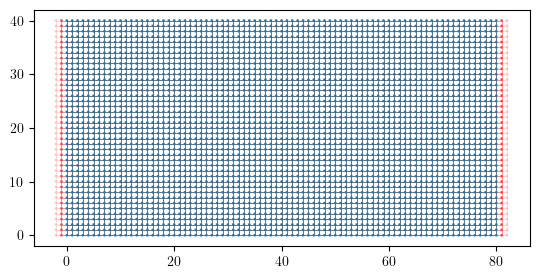

Number of nodes:  3321
Number of hoppings:  13040


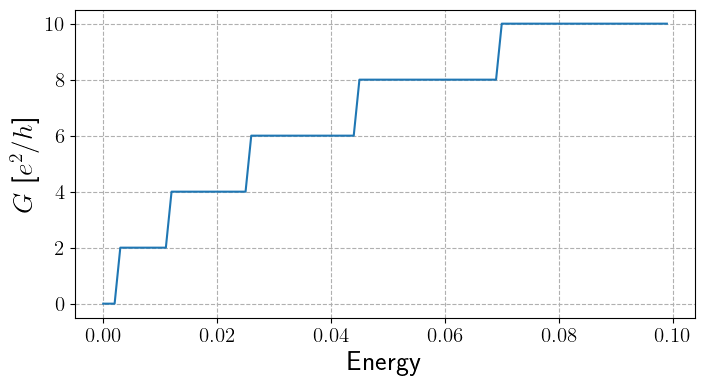

In [5]:
atry = 1.
Lmax = 80
Wmax = 40
Bz = 0.05 * 0
alphaR = 0.25 * 0

system = make_box(atry, Lmax, Wmax, Bz, alphaR, 'yes', 'yes')

energies = [0.001 * i  for i in range(100)]

conductance_energy(system, energies, Bz, alphaR)

3321


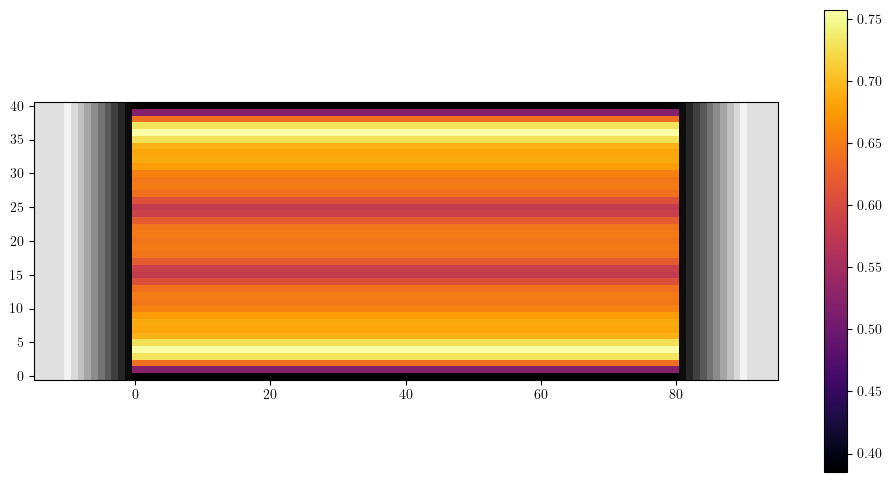

In [25]:
etry = 2.05

local_dos_up = dos_box(system, etry,'up')

### **The closed system.**

Let's consider the case of a closed system, i.e. no leads attached. We can compute the spectrum of the Hamiltonian and plot the wavefunctions. Check the twin code `RSOC-v1-billiard.ipynb` for the same calculation with the scattering region being shaped as a billiard (stadium?).
We proceed as
1. We engineer the system by calling `make_box`, passing `no` to `lead_choice` 
2. We extract the hamiltonian submatrix corresponding to the scattering region
3. Let's call a `scipy` routine to compute eigenvalues and eigenstates

**IMPORTANT REMARK.** Consider that the Rashba hamiltonian can be easily brought into momentum space (no dependence of the parameters on the position).

In [30]:
def closed_box(a: float, Lmax: int, Wmax: float, alpha: float, Bz: float, eigenplot: int):

    # define a system with no leads attached
    lead_choice = 'no'
    plot_choice = 'yes' # maybe we want to plot the system, if so change to yes

    system = make_box(a, Lmax, Wmax, alpha, Bz, lead_choice, plot_choice) 

    # compute the Hamiltonian matrix
    ham_mat = system.hamiltonian_submatrix(sparse = True)

    # compute the lowest imax  eigenvalues
    # i'm calling the shift-invert mode (see scipy docs) ---> sigma specifies the target, 'LM' tells to find the largest eigenvalues (in magnitude) close to target
    # i have a feeling that the true eigenstates has energy a little bit below the scale set by Bz
    # if one moves sigma (i.e. targe) below we continue to find the same eigenvalues 
    imax = 10 # number of eigenvalues to compute
    
    # sort the eigenvalues --> lower energies first, so [0] is the ground state
    def sorted_eigs(ev):
        
        evals, evecs = ev
        evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
        return evals, evecs.transpose()

    # compute eigenvalues and eigenvectors via the shift-inverted method
    # TRICK: I'm telling the algorithm to look for eigenvalues close to -10 * Bz, since spectrum is bounded from below
    #        and it is the Zeeman term the one responsible for pushing up and down the bands 
    evals, evecs = sorted_eigs(sla.eigsh(ham_mat, k = imax, sigma = -20 * Bz, which = 'LM', return_eigenvectors = True))

    for i in range(imax):
        print('Eigenvalue ', i, ' = ', evals[i])

    if eigenplot < imax and eigenplot >= 0:
        print('Plotted eigenmode ', eigenplot, ' with energy ', evals[eigenplot])
        # Plot the probability density of the  eigenmode.
        psi_sq = np.abs(evecs[:, eigenplot])**2
        psi_sq = psi_sq.reshape(-1,2)
        psi_sq_up = psi_sq[:,0]
        psi_sq_down = psi_sq[:,1]

        kwant.plotter.map(system, psi_sq_down, colorbar=True, oversampling=1, fig_size=(12,6))
        kwant.plotter.map(system, psi_sq_up, colorbar=True, oversampling=1, fig_size=(12,6))
    else:
        print('Please select a valid eigenmode to plot, between 0 and ', imax-1)

Hopping energy [t] =  0.5


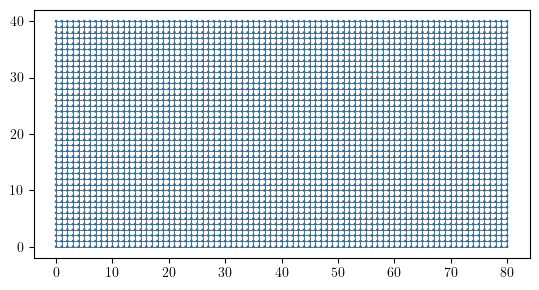

Eigenvalue  0  =  -0.24650188594019218
Eigenvalue  1  =  -0.2443222789793702
Eigenvalue  2  =  -0.24069306361448328
Eigenvalue  3  =  -0.23820337051453677
Eigenvalue  4  =  -0.23602375769915718
Eigenvalue  5  =  -0.23561942944962944
Eigenvalue  6  =  -0.232394532573168
Eigenvalue  7  =  -0.22910863258655745
Eigenvalue  8  =  -0.22732088463056765
Eigenvalue  9  =  -0.22442304049601303
Plotted eigenmode  9  with energy  -0.22442304049601303


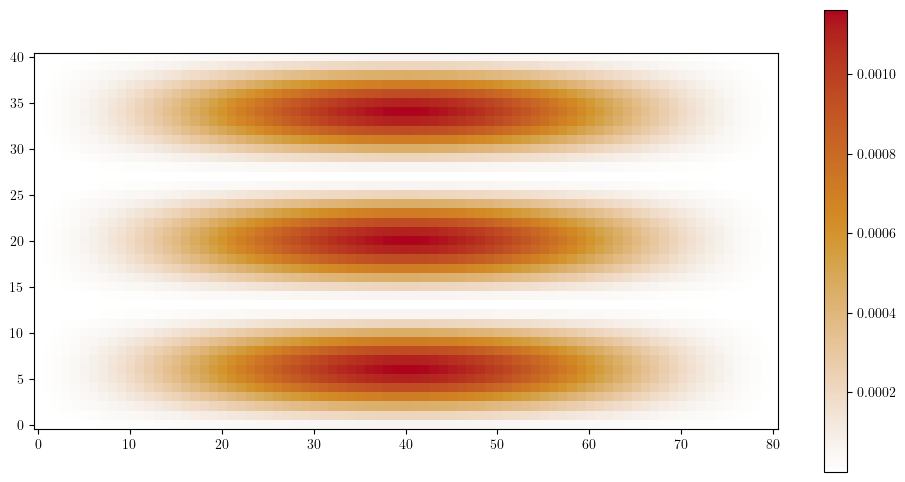

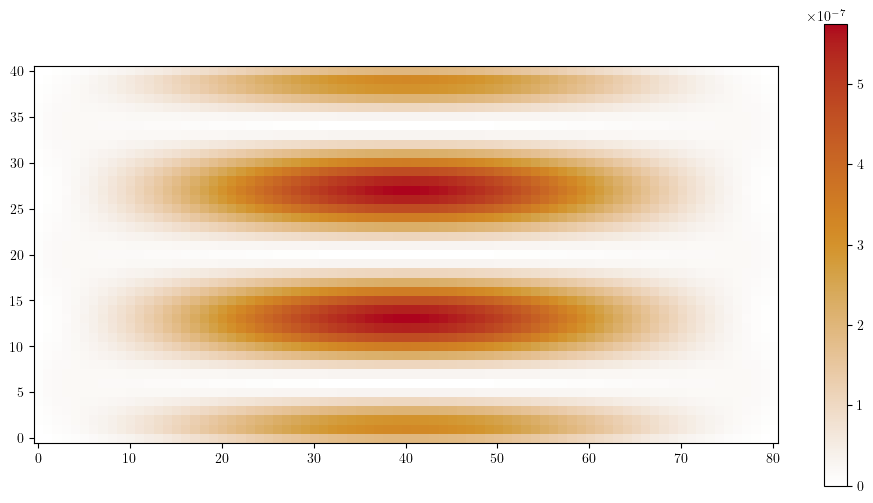

In [33]:
atry = 1.
Lmax = 80
Wmax = 40
Bz = 0.05
alphaR = 0.25

closed_box(atry, Lmax, Wmax, alphaR, Bz, 9)

### **The closed system - Spectrum and control parameters.** 

We continue studying the closed billiard in presence of Rashba SOC. Now, we aim to investigate how changes in physical parameters such as the magnetic (Zeeman) field $B_z$ or the spin-orbit coupling strength $\alpha_R$ affect the spectrum of the system. Physically speaking, I would argue it is easier to control the SOC strength since the electric field can be reabsorbed in it, and an electric field is easier to tune.

**Work in progress**

In [ ]:
def box_spectrum_B(a: float, Lmax: int, Wmax: int, alpha_max: float, Bz_max: float, which_params: str):

    # some global scope variables
    lead_choice = 'no'
    plot_choice = 'no'

    # number of eigenvalues to compute
    imax = 15

    # sort the eigenvalues --> lower energies first, so [0] is the ground state
    def sorted_eigs(ev):
        
        evals, evecs = ev
        evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
        return evals, evecs.transpose()


    # which_params = 'Bz' or 'alpha'
    if which_params == 'Bz':
        
        Bz = np.linspace(0.01, Bz_max, 50)
        alpha = alpha_max
        
        # prepare an empty array where to store the eigenvalues
        evals_Bz = np.zeros((len(Bz), imax))

        # prepare the file to store the output 
        with open('box_spectrum_Bz.txt', 'w') as f:
            # compute the spectrum - consider the trick in calling the shift-inverted method, see above
            for i, Bz_i in enumerate(Bz):
                system = make_box(a, Lmax, Wmax, alpha, Bz_i, lead_choice, plot_choice)
                ham_mat_run = system.hamiltonian_submatrix(sparse = True)
                evals_run, evecs_run = sorted_eigs(sla.eigsh(ham_mat_run, k = imax, sigma = - 20 * Bz_i, which = 'LM', return_eigenvectors = True))
                evals_Bz[i,:] = evals_run
                # save Bz_i and evals_run to file 
                f.write(str(Bz_i) + ' ' + ' '.join(map(str, evals_run)) + '\n')

            return Bz, evals_Bz
    
    elif which_params == 'alpha':

        alpha = np.linspace(0.01, alpha_max, 50)
        Bz = Bz_max

        # prepare an empty array where to store the eigenvalues
        evals_alpha = np.zeros((len(alpha), imax))

        # prepare the file to store the output
        with open('box_spectrum_alpha.txt', 'w') as f:
        # compute the spectrum - consider the trick in calling the shift-inverted method, see above
            for i, alpha_i in enumerate(alpha):
                system = make_box(a, Lmax, Wmax, alpha_i, Bz, lead_choice, plot_choice)
                ham_mat_run = system.hamiltonian_submatrix(sparse = True)
                evals_run, evecs_run = sorted_eigs(sla.eigsh(ham_mat_run, k = imax, sigma = - 20 * Bz, which = 'LM', return_eigenvectors = True))
                evals_alpha[i,:] = evals_run
                # save alpha_i and evals_run to file
                f.write(str(alpha_i) + ' ' + ' '.join(map(str, evals_run)) + '\n')

            return alpha, evals_alpha

    else:
        print('Please select a valid parameter to vary: Bz or alpha')

In [36]:
Bz = 0.5
alpha = 0.5

magnetic_fields, spectrum = box_spectrum_B(atry, Lmax, Wmax, alpha, Bz, 'Bz')

Text(0.5, 1.0, '$\\alpha = $0.5')

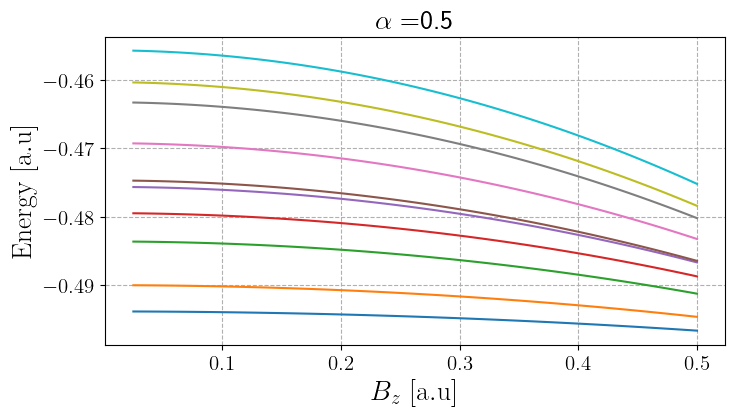

In [37]:
fig_Bz, ax_Bz = plt.subplots(1,1, figsize=(8,4))
ax_Bz.plot(magnetic_fields, spectrum)
ax_Bz.set_xlabel(r'$B_z$ $\mathrm{[a.u]}$',fontsize=20)
ax_Bz.set_ylabel(r'$\mathrm{Energy}$ $\mathrm{[a.u]}$',fontsize=20)
ax_Bz.tick_params(axis='both', labelsize=15)
ax_Bz.grid(linestyle='--')
ax_Bz.set_title(r'$\alpha = $' + str(alpha), fontsize=20)
#ax_Bz.set_xlim(0.7, 0.75)
#ax_Bz.set_ylim(-0.505, -0.480)